# Environment Setup

## Imports and trivial functions

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from pprint import pprint
import random
import operator

def pretty_print(two_d_array: list) -> None:
    for i in two_d_array:
        pv = [round(x, 2) for x in i]
        print(*pv, sep='\t')

## Setting up State Space

In [286]:
state_space = np.zeros((5, 10))
for i in range(0, len(state_space)-1):
    for j in range(0, len(state_space[i]-1)):
        state_space[i][j] = -1
for i in range(0, len(state_space[-1])):
    if 0 < i and i < len(state_space[-1])-1:
        state_space[-1][i] = -100
    elif i == len(state_space[-1])-1:
        state_space[-1][i] = 20
original_state_space = copy.deepcopy(state_space)
print(state_space)

[[  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
 [   0. -100. -100. -100. -100. -100. -100. -100. -100.   20.]]


## Define possible actions for each state

In [287]:
possible_actions = {}
for i in range(0, len(state_space)):
    for j in range(0, len(state_space[i])):
        list_of_actions = []
        # Each state has a maximum of 4 possible actions (New states to transition to)
        # We check the boundaries to ensure we do not add an action outside our state space
        if not (i-1 < 0):
            list_of_actions.append((i-1, j))
        if not (i+1 >= len(state_space)):
            list_of_actions.append((i+1, j))
        if not (j-1 < 0):
            list_of_actions.append((i, j-1))
        if not(j+1 >= len(state_space[i])):
            list_of_actions.append((i, j+1))
        possible_actions[(i, j)]= list_of_actions
pprint(possible_actions)

{(0, 0): [(1, 0), (0, 1)],
 (0, 1): [(1, 1), (0, 0), (0, 2)],
 (0, 2): [(1, 2), (0, 1), (0, 3)],
 (0, 3): [(1, 3), (0, 2), (0, 4)],
 (0, 4): [(1, 4), (0, 3), (0, 5)],
 (0, 5): [(1, 5), (0, 4), (0, 6)],
 (0, 6): [(1, 6), (0, 5), (0, 7)],
 (0, 7): [(1, 7), (0, 6), (0, 8)],
 (0, 8): [(1, 8), (0, 7), (0, 9)],
 (0, 9): [(1, 9), (0, 8)],
 (1, 0): [(0, 0), (2, 0), (1, 1)],
 (1, 1): [(0, 1), (2, 1), (1, 0), (1, 2)],
 (1, 2): [(0, 2), (2, 2), (1, 1), (1, 3)],
 (1, 3): [(0, 3), (2, 3), (1, 2), (1, 4)],
 (1, 4): [(0, 4), (2, 4), (1, 3), (1, 5)],
 (1, 5): [(0, 5), (2, 5), (1, 4), (1, 6)],
 (1, 6): [(0, 6), (2, 6), (1, 5), (1, 7)],
 (1, 7): [(0, 7), (2, 7), (1, 6), (1, 8)],
 (1, 8): [(0, 8), (2, 8), (1, 7), (1, 9)],
 (1, 9): [(0, 9), (2, 9), (1, 8)],
 (2, 0): [(1, 0), (3, 0), (2, 1)],
 (2, 1): [(1, 1), (3, 1), (2, 0), (2, 2)],
 (2, 2): [(1, 2), (3, 2), (2, 1), (2, 3)],
 (2, 3): [(1, 3), (3, 3), (2, 2), (2, 4)],
 (2, 4): [(1, 4), (3, 4), (2, 3), (2, 5)],
 (2, 5): [(1, 5), (3, 5), (2, 4), (2, 6)],
 (

### Defining the start node and the terminal states

In [288]:
init_state = (4, 0)
terminal_states = [(4, x) for x in range(1, len(state_space[-1]))]

## $\epsilon$-greedy Policy

In [289]:
# input: State Space, current state, List of possible actions (locations), epsilon value
# returns: new action (location tuple)
def policy(current_state: tuple, e: float = 0.1) -> tuple:
    action_payoffs = {}
    # retreiving payoffs of possible actions
    for action in possible_actions[current_state]:
        i, j = action
        action_payoffs[action] = state_space[i][j]
    # Decide with the e-greedy policy the action to return
    if random.random() > e:
        return max(action_payoffs, key=action_payoffs.get)
    return random.choice(list(action_payoffs.keys()))

# SARSA

Input: 
- Starting state 
- List of terminal states
- Iteration limit
- Learning rate $\alpha$
- Discount factor $\gamma$
- Policy value $\epsilon$

In [290]:
def SARSA(init: tuple, terminal_states: list, limit: int,
          alpha: float, gamma: float, epsilon: float) -> list:
    for _ in range(0, limit):
        current_state = copy.deepcopy(init)
        action = policy(current_state=current_state, e=epsilon)
        while current_state not in terminal_states: #True:
            # retreive best action from policy
            action = policy(current_state=current_state, e=epsilon) 
            i, j = current_state
            k, l = action

            # SARSA Update rule
            state_space[i][j] += alpha * (original_state_space[k][l] 
                              + (gamma * state_space[k][l]) - state_space[i][j])

            # Move to next state
            current_state = action
            # if current_state in terminal_states:
            #    break
    return state_space

# Q-Learning

In [291]:
def Q_Learning(init: tuple, terminal_states: list, limit: int,
          alpha: float, gamma: float, epsilon: float) -> list:
    for _ in range(0, limit):
        current_state = copy.deepcopy(init)
        action = policy(current_state=current_state, e=epsilon)
        while current_state not in terminal_states: #True:
            # retreive best action from policy
            action = policy(current_state=current_state, e=epsilon)

            # retreiving list of possible pay-offs from current state
            action_payoffs = {}
            for act in possible_actions[current_state]:
                a, b = act
                action_payoffs[act] = state_space[a][b]
            
            i, j = current_state
            k, l = max(action_payoffs, key=action_payoffs.get)

            # Q-Learning update rule (Utilising max pay-off possible)
            state_space[i][j] += alpha * (original_state_space[i][j] 
                              + (gamma * state_space[k][l]) - state_space[i][j])
            
            # Moving to new state chosen by policy
            current_state = action
            #if current_state in terminal_states:
            #    break
    return state_space

# Tests

## SARSA Test

SARSA Test
-2.41	-2.96	-22.9	0.36	-0.1	-10.01	-17.31	-66.49	-15.93	-16.66
-1.53	-0.59	0.46	1.62	2.91	4.35	5.94	7.71	7.94	9.24
1.23	2.48	3.87	5.41	7.12	9.02	11.13	13.48	16.09	18.99
0.11	-0.61	-1.24	0.17	2.6	7.62	9.68	11.87	14.3	36.36
-0.9	-100.0	-100.0	-100.0	-100.0	-100.0	-100.0	-100.0	-100.0	20.0


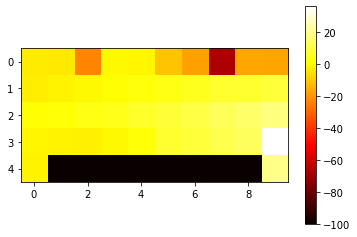

In [306]:
def SARSA_test(limit, alpha, gamma, epsilon) -> None:
    state_space = SARSA(init_state, terminal_states, limit=limit, alpha=alpha, gamma=gamma, epsilon=epsilon)
    pretty_print(state_space)
    heatmap = plt.imshow(state_space, cmap='hot', interpolation='nearest')
    plt.colorbar(heatmap) 
    plt.show()

    state_space = copy.deepcopy(original_state_space)

print('SARSA Test')
SARSA_test(limit=1000, alpha=0.9, gamma=0.9, epsilon=0)

## Q-Learning Test

Q-Learning Test
-2.41	-2.96	-22.9	0.36	-0.1	-10.01	-17.31	-66.49	-15.93	-16.66
-1.53	-0.59	0.46	1.62	2.91	4.35	5.94	7.71	7.94	9.24
-0.59	0.46	1.62	2.91	4.35	5.94	7.71	9.68	11.87	14.3
-1.53	-0.61	-1.24	0.17	2.6	7.62	9.68	11.87	14.3	17.0
-1.37	-100.0	-100.0	-100.0	-100.0	-100.0	-100.0	-100.0	-100.0	20.0


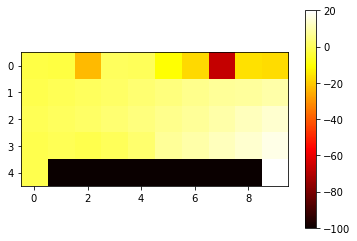

In [304]:
def Q_test(limit, alpha, gamma, epsilon) -> None:
    state_space = Q_Learning(init_state, terminal_states, limit=limit, alpha=alpha, gamma=gamma, epsilon=epsilon)
    pretty_print(state_space)
    heatmap = plt.imshow(state_space, cmap='hot', interpolation='nearest')
    plt.colorbar(heatmap)    
    plt.show()

    state_space = copy.deepcopy(original_state_space)
print('Q-Learning Test')
Q_test(limit=1000, alpha=0.9, gamma=0.9, epsilon=0)
